In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

In [0]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torchvision.datasets import SVHN
from torchbearer import Trial
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

%matplotlib inline

In [0]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Loading the SVHN dataset in which there are just individual digit info. This dataset is provided by torchvision. But it is not the main dataset that we have to use. I just import it and define the loaders for later. We can run our CNN to test indv digit accuracy

In [5]:
# convert each image to tensor format
transform = transforms.Compose([
    transforms.ToTensor()  # convert to tensor
])

# load data
trainset = SVHN(root='.', split='train', transform=transform, download=True)

testset = SVHN(root=".", split='test', transform=transform, download=True)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

0it [00:00, ?it/s]

100%|█████████▉| 181706752/182040794 [00:57<00:00, 4556572.63it/s]
0it [00:00, ?it/s]


 99%|█████████▉| 63619072/64275384 [00:09<00:00, 19370951.06it/s]

In [0]:
# per-digit dataset

for i, data in enumerate(trainloader):
  print (i, data[0].shape, data[1])
  break

0 torch.Size([128, 3, 32, 32]) tensor([2, 1, 3, 2, 1, 2, 2, 4, 9, 4, 4, 3, 2, 2, 2, 4, 5, 6, 4, 0, 2, 5, 8, 7,
        5, 2, 7, 6, 0, 4, 4, 3, 2, 9, 4, 9, 1, 3, 1, 8, 5, 1, 3, 7, 5, 7, 1, 1,
        6, 1, 4, 2, 8, 4, 0, 6, 7, 7, 8, 1, 9, 2, 5, 0, 8, 8, 8, 3, 1, 3, 4, 1,
        2, 4, 6, 1, 6, 5, 0, 2, 1, 2, 4, 1, 9, 7, 6, 5, 4, 3, 9, 0, 1, 5, 2, 4,
        2, 1, 7, 1, 5, 1, 9, 2, 5, 4, 0, 6, 4, 2, 0, 0, 9, 3, 0, 7, 5, 8, 2, 3,
        4, 6, 2, 2, 2, 1, 3, 6])


In [0]:
# These are all the modules we'll be using later.
from __future__ import print_function
import numpy as np

from six.moves import cPickle as pickle
from six.moves import range

import os
import sys
import tarfile
from IPython.display import display, Image

import h5py

import matplotlib.pyplot as plt

from PIL import Image
import random

In [7]:
from collections import Counter
%matplotlib inline
from urllib.request import urlretrieve

182042624it [01:10, 4556572.63it/s]                               

This block of code just downloads the relevant files and extracts them to the local directory. Dont need to understand deeply

In [8]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

train_filename = maybe_download('train.tar.gz', 404141560 )
test_filename = maybe_download('test.tar.gz', 276555967 )

Found and verified train.tar.gz
Found and verified test.tar.gz


### Extract the data

In [9]:
# places the extracted files in /train and /test

num_classes = 10
np.random.seed(133)

train_filename = 'train.tar.gz'
test_filename = 'test.tar.gz'
# extra_filename = 'extra.tar.gz'

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    if not os.path.exists(root+'/digitStruct.mat'):
        print("digitStruct.mat is missing")
    return root + '/digitStruct.mat'
  
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


### Read the dataset

In [0]:
print(train_folders)


train/digitStruct.mat


In [11]:
train_dataset = h5py.File(train_folders, "r")

print (list(train_dataset.keys()))

['#refs#', 'digitStruct']


In [0]:
list(train_dataset['digitStruct'].items())

[('bbox', <HDF5 dataset "bbox": shape (33402, 1), type "|O">),
 ('name', <HDF5 dataset "name": shape (33402, 1), type "|O">)]

Basically this means that there are 33402 file names and each of these files has a corr bbox struct which contains info about the images



In [0]:
list(train_dataset['digitStruct'].items())[0][1][0][0]

<HDF5 object reference>

This code block basically transorms all the .mat stuff into python dicts and obj. Basically it does everything Hannah explained

In [0]:
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [0]:
train = DigitStructFile(train_folders)
train_data = train.getAllDigitStructure_ByDigit()


test = DigitStructFile(test_folders)
test_data = test.getAllDigitStructure_ByDigit()

In [14]:
print ("Len of train data:", len(train_data))
print ("Len of test data:", len(test_data))


print (train_data[0])

print (train_data[1])

print (test_data[13])

Len of train data: 33402
Len of test data: 13068
{'filename': '1.png', 'boxes': [{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]}
{'filename': '2.png', 'boxes': [{'height': 32.0, 'label': 2.0, 'left': 77.0, 'top': 29.0, 'width': 23.0}, {'height': 32.0, 'label': 3.0, 'left': 98.0, 'top': 25.0, 'width': 26.0}]}
{'filename': '14.png', 'boxes': [{'height': 24.0, 'label': 2.0, 'left': 64.0, 'top': 27.0, 'width': 13.0}, {'height': 24.0, 'label': 5.0, 'left': 80.0, 'top': 23.0, 'width': 13.0}]}


Basically `train` contains info about file_name the bounding boxes and the labels of the images. But where are the indv pixel values

Structure:

```
{'filename': '1.png',
'boxes', [..label of each indv digit and its bounding box coords ]
```

In [0]:
# save digitStruct information into a pickle
pickle_file = 'multi_bbox_info.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_data': train_data,
    'test_data': test_data,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [16]:
pickle_file = 'multi_bbox_info.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_data = save['train_data']
    test_data = save['test_data']
    del save
    print('Training set', len(train_data))
    print('Test set', len(test_data))
    print (train_data[0])

    print (train_data[1])

    print (test_data[13])

Training set 33402
Test set 13068
{'filename': '1.png', 'boxes': [{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]}
{'filename': '2.png', 'boxes': [{'height': 32.0, 'label': 2.0, 'left': 77.0, 'top': 29.0, 'width': 23.0}, {'height': 32.0, 'label': 3.0, 'left': 98.0, 'top': 25.0, 'width': 26.0}]}
{'filename': '14.png', 'boxes': [{'height': 24.0, 'label': 2.0, 'left': 64.0, 'top': 27.0, 'width': 13.0}, {'height': 24.0, 'label': 5.0, 'left': 80.0, 'top': 23.0, 'width': 13.0}]}


### Generate dataset

crop images and save them to numpy ndarray

In [0]:
np.ones(shape=(10, 6), dtype='int')*10

array([[10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10]])

In [0]:
class Dataset:
  """crop images and save them to numpy ndarray"""
  
  # digitStruct is train_data
  
  def __init__(self, digitStruct, folder):
    self.digitStruct = digitStruct
    self.folder = folder
    
  def setDataset(self):
    # set the data (images) as proper 
    # len(self.digitStruct) is 33402
    # basically initializing dataset as 33402x64x64
    self.dataset = np.ndarray(shape=(len(self.digitStruct), 54, 54), dtype='float32')
    
    #set the labels
    
    # 1 length + 5 labels, 10 represents none
    
    self.labels = np.ones(shape=(len(self.digitStruct), 6), dtype='int')*10
    
  def getDataset(self):
    # initialize the data structures
    self.setDataset()
    
    # for each train file
    for i in range(len(self.digitStruct)):
      # get file_name for the img
      fin = os.path.join(self.folder, self.digitStruct[i]['filename'])
      
      # open the file
      im = Image.open(fin)
      
      # get the 'boxes'  key
      
      boxes = self.digitStruct[i]['boxes']
      
      # check for >5 digits
      if len(boxes) > 5:
        print(fin, "has more than 5 digits")
      else:
        # first index of labels contains number of digits and that is the len of 'boxes'
        self.labels[i, 0] = len(boxes)
        # set the labels for each digit in this file
        self.labels[i, 1: len(boxes)+1] = [int(box['label']) for box in boxes]
        
      # set the L,T,W,H params foreach digit in this file
      left = [box['left'] for box in boxes]
      top = [box['top'] for box in boxes]
      height = [box['height'] for box in boxes]
      width = [box['width'] for box in boxes]
      
      
      # get the new expanded bounding boxes over the ENTIRE MULTI DIGIT IMAGE
      box = self.im_box(im, left, top, height, width)
      
      size = (64,64)
      
      # crop acc to the new bounding box and resize to the desired shape for training the CNN
      region = im.crop(box).resize(size)
      # normalize the 64x64 img
      region = self.normalization(region)
      
      rand_x = random.randrange(10)
      rand_y = random.randrange(10)
      region = region[rand_x:rand_x+54,rand_y:rand_y+54]
      
      
      # replace the original img with this pre-processed 64x64 img
      
      self.dataset[i, :, :] = region[:,:]
      
    print('dataset:',self.dataset.shape)
    print('labels:',self.labels.shape)
    return self.dataset, self.labels
      
      
      
      
  def im_box(self, im, left, top, height, width):
    
    im_left = min(left) # get leftmost line
    im_top = min(top) # topmost line
    
    im_height = max(top) + max(height) - im_top # max(ht) + ( max(top) - min(top) )
    im_width = max(left) + max(width) - im_left # max(width) + (max(left) - min(left))
    
    # basically im_height is the ht of tallest digit + some margin
    # basically im_width is the width of widest digit + some margin
    
    # can experiment with 0.05
    im_top = im_top - im_height*0.05 # bit higher than topmost line
    im_left = im_left - im_width*0.05 # bit more towards the left(wider) than leftmost line  
    
    # width, height = im.size
    
    im_bottom = min(im.size[1], im_top + im_height*1.05) # can experiment with 1.05
    
    # from the topmost line go down to ht and a bit more
    # get the min out of that or the image ht
    
    im_right = min(im.size[0], im_left + im_width*1.05)
    
    # from the leftmost line go right to width and a bit more
    # get the min out of that or the image width
    
    # (im_left, im_top, im_right, im_bottom) are the coords of the 
    # new expanded bounding boxes over the ENTIRE MULTI DIGIT IMAGE
    
    return (im_left, im_top, im_right, im_bottom)
    
  def normalization(self, img):
    im = self.rgb2gray(img) # RGB to greyscale
    mean = np.mean(im, dtype='float32')
    std = np.std(im, dtype='float32', ddof=1)
    return (im - mean) / std  
  
  def rgb2gray(self, img):
    # L = R * 299/1000 + G * 587/1000 + B * 114/1000
    return np.dot(np.array(img), [0.299, 0.587, 0.114])
        
      
      

### train dataset

In [159]:
train_dataset = Dataset(train_data, 'train')

train_dataset, train_labels = train_dataset.getDataset()

train/29930.png has more than 5 digits
dataset: (33402, 54, 54)
labels: (33402, 6)


In [160]:
print ("Len of train set:", len(train_dataset))
print(train_dataset[0].shape)
print (train_labels[0])
print (train_labels[0].shape)

Len of train set: 33402
(54, 54)
[ 2  1  9 10 10 10]
(6,)


In [161]:
print (train_labels[29929])

[10 10 10 10 10 10]


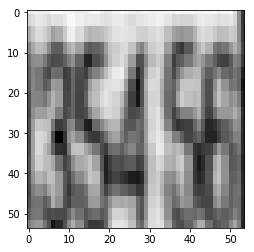

In [162]:
plt.imshow(train_dataset[29929,:,:], cmap='gray');

Delete this image

In [0]:
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

In [164]:
print(train_dataset.shape)
print(train_labels.shape)


(33401, 54, 54)
(33401, 6)


### Test data

In [165]:
test_dataset = Dataset(test_data, 'test')
test_dataset, test_labels = test_dataset.getDataset()

dataset: (13068, 54, 54)
labels: (13068, 6)


### Creating a validation dataset

In [166]:
np.random.seed(1234)
np.random.permutation(10)

array([7, 2, 9, 1, 0, 8, 4, 5, 6, 3])

#### Shuffle the dataset

In [167]:
def randomize(dataset, labels):
  np.random.seed(1234)
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

print (train_dataset.shape, train_labels.shape)
print (test_dataset.shape, test_labels.shape)

(33401, 54, 54) (33401, 6)
(13068, 54, 54) (13068, 6)


In [168]:
train_portion = 6000
valid_dataset = train_dataset[:train_portion,:,:]
valid_labels = train_labels[:train_portion]
train_dataset = train_dataset[train_portion:,:,:]
train_labels = train_labels[train_portion:]
                             
print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(27401, 54, 54) (27401, 6)
(13068, 54, 54) (13068, 6)
(6000, 54, 54) (6000, 6)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


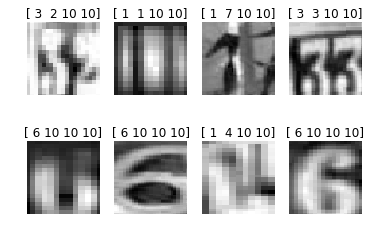

In [169]:
def disp_sample_dataset(dataset, label):
    items = random.sample(range(dataset.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label[i][1:5])
        plt.imshow(dataset[i,:,:], cmap='gray')
disp_sample_dataset(train_dataset, train_labels)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


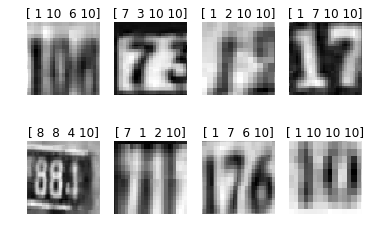

In [170]:
disp_sample_dataset(test_dataset, test_labels)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


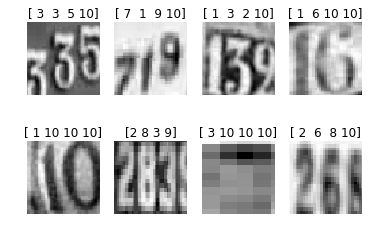

In [171]:
disp_sample_dataset(valid_dataset, valid_labels)


### Save dataset

In [27]:
pickle_file = 'SVHN_multi_crop.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print("Done")
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Done


## REPRODUCIBILITY: Run From Here

Make sure you download the `SVHN_multi_crop.pickle` from [here](https://drive.google.com/open?id=1LucH2BJJvs9ULOMzXagrIqOwnBey5HTC)

#### Import the libraries

In [28]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer
    
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torchvision.datasets import SVHN
from torchbearer import Trial
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms


from __future__ import print_function
import numpy as np
from six.moves import cPickle as pickle


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
pickle_file = 'SVHN_multi_crop.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    # del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (27401, 54, 54) (27401, 6)
Validation set (6000, 54, 54) (6000, 6)
Test set (13068, 54, 54) (13068, 6)


In [30]:
print ("Train dataset info: {} images of size {}x{}".format(train_dataset.shape[0], train_dataset.shape[1], train_dataset.shape[2]))

print ("Test dataset info: {} images of size {}x{}".format(test_dataset.shape[0], test_dataset.shape[1], test_dataset.shape[2]))

print ("Valid dataset info: {} images of size {}x{}".format(valid_dataset.shape[0], valid_dataset.shape[1], valid_dataset.shape[2]))

Train dataset info: 27401 images of size 54x54
Test dataset info: 13068 images of size 54x54
Valid dataset info: 6000 images of size 54x54


[number_of_digits, 1st digit, 2nd, 3rd, 4th 5th]

In [0]:
train_labels[0]

array([ 2,  3,  2, 10, 10, 10])

### Creating DataLoaders

In [0]:
class SVHNImageDataset(Dataset):
  def __init__(self, dataset_object, label_object, transform=None):
    self.data = dataset_object
    self.labels = label_object
    self.transform = transform
    
  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, index):

    image = self.data[index]
    label = self.labels[index]
    
    return image,label

In [0]:
# create datasets of SVHNImageDataset class

train_dataset_new = SVHNImageDataset(train_dataset, train_labels, transform=None)
test_dataset_new = SVHNImageDataset(test_dataset, test_labels, transform=None)
valid_dataset_new = SVHNImageDataset(valid_dataset, valid_labels, transform=None)

In [174]:
img, label = train_dataset_new.__getitem__(0)

print (img.shape, label.shape)

print (len(train_dataset_new))

(54, 54) (6,)
27401


Now we create the DataLoaders

In [0]:
train_loader = DataLoader(train_dataset_new, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset_new, batch_size=8, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset_new, batch_size=8, shuffle=True, drop_last=True)


Making sure that the data and the labels are of class: `Tensor` and everything is of correct shape

In [176]:
for i, (data, label) in enumerate(train_loader):
  print (type(data), type(label))
  print (data.shape, label.shape)
  break
  
for i, (data, label) in enumerate(test_loader):
  print (type(data), type(label))
  print (data.shape, label.shape)
  break
  
for i, (data, label) in enumerate(valid_loader):
  print (type(data), type(label))
  print (data.shape, label.shape)
  break

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([8, 54, 54]) torch.Size([8, 6])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([8, 54, 54]) torch.Size([8, 6])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([8, 54, 54]) torch.Size([8, 6])


The shape is now `[batch_size, 64, 64]` for the data and `[batch_size, 6]` for the labels

Just plotting some of the images and labels from the DataLoaders to make sure everything is OK

tensor([ 2,  9,  5, 10, 10, 10])
tensor([ 2,  5,  1, 10, 10, 10])
tensor([ 2,  4,  4, 10, 10, 10])
tensor([ 3,  1,  1,  5, 10, 10])
tensor([ 3,  3, 10,  3, 10, 10])
tensor([ 3,  2,  6,  7, 10, 10])
tensor([ 1,  1, 10, 10, 10, 10])
tensor([ 2,  6,  4, 10, 10, 10])


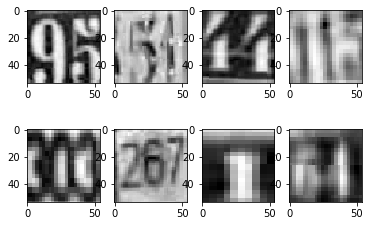

In [177]:
for i, (data, label) in enumerate(train_loader):
  first_batch = data
  for x in range(first_batch.shape[0]):
    plt.subplot(int(str(24)+str(x+1)))
    plt.imshow(first_batch[x], cmap="gray")
    print (label[x])
  break
    
plt.show()

tensor([ 3,  1, 10,  4, 10, 10])
tensor([ 2,  2,  2, 10, 10, 10])
tensor([ 3,  4,  7, 10, 10, 10])
tensor([ 2,  3,  6, 10, 10, 10])
tensor([ 2,  4,  3, 10, 10, 10])
tensor([ 1,  7, 10, 10, 10, 10])
tensor([ 2,  6,  7, 10, 10, 10])
tensor([ 1,  9, 10, 10, 10, 10])


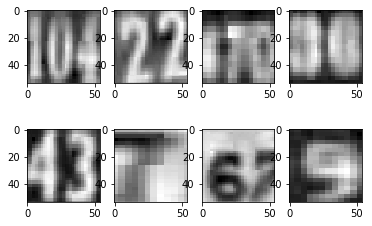

In [178]:
for i, (data, label) in enumerate(test_loader):
  first_batch = data
  for x in range(first_batch.shape[0]):
    plt.subplot(int(str(24)+str(x+1)))
    plt.imshow(first_batch[x], cmap="gray")
    print (label[x])
  break
    
plt.show()

tensor([ 2,  1,  5, 10, 10, 10])
tensor([ 3,  1,  4,  8, 10, 10])
tensor([ 2,  6,  1, 10, 10, 10])
tensor([ 2,  3,  3, 10, 10, 10])
tensor([ 1,  1, 10, 10, 10, 10])
tensor([ 2,  1,  6, 10, 10, 10])
tensor([ 2,  4,  7, 10, 10, 10])
tensor([ 2,  7,  1, 10, 10, 10])


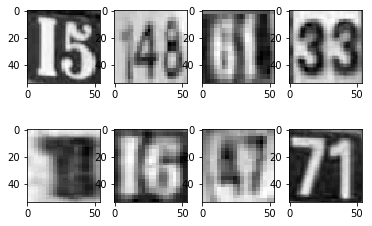

In [0]:
for i, (data, label) in enumerate(valid_loader):
  first_batch = data
  for x in range(first_batch.shape[0]):
    plt.subplot(int(str(24)+str(x+1)))
    plt.imshow(first_batch[x], cmap="gray")
    print (label[x])
  break
    
plt.show()

### Check the lables and data

In [0]:
for i, (data, label) in enumerate(train_loader):
  if label.shape[0] != 8 or label.shape[1]!=6:
    print (i)
  

In [0]:
for i, (data, label) in enumerate(train_loader):
  if label[:, 0].max().item() > 5:
    print (label)
 
  

### DataLoaders ready for use

### Create a simple CNN

#### Things to do:

1. Max out
2. BatchNormalization
3. Dropout

In [0]:
class MainModel(nn.Module):
    def __init__(self):
        super(MainModel, self).__init__()

        self._hidden1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=48, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=160, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=160),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden5 = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden7 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden8 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden9 = nn.Sequential(
            nn.Linear(192 * 7 * 7, 3072),
            nn.ReLU()
        )
        self._hidden10 = nn.Sequential(
            nn.Linear(3072, 3072),
            nn.ReLU()
        )

        self._digit_length = nn.Sequential(nn.Linear(3072, 7))
        self._digit1 = nn.Sequential(nn.Linear(3072, 11))
        self._digit2 = nn.Sequential(nn.Linear(3072, 11))
        self._digit3 = nn.Sequential(nn.Linear(3072, 11))
        self._digit4 = nn.Sequential(nn.Linear(3072, 11))
        self._digit5 = nn.Sequential(nn.Linear(3072, 11))

    def forward(self, x):
        x = self._hidden1(x)
        x = self._hidden2(x)
        x = self._hidden3(x)
        x = self._hidden4(x)
        x = self._hidden5(x)
        x = self._hidden6(x)
        x = self._hidden7(x)
        x = self._hidden8(x)
        x = x.view(x.size(0), 192 * 7 * 7)
        x = self._hidden9(x)
        x = self._hidden10(x)

        length_logits = self._digit_length(x)
        
        
        digit1_logits = self._digit1(x)
        digit2_logits = self._digit2(x)
        digit3_logits = self._digit3(x)
        digit4_logits = self._digit4(x)
        digit5_logits = self._digit5(x)
        
        

        return length_logits, digit1_logits, digit2_logits, digit3_logits, digit4_logits, digit5_logits

SImple CNN

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 5), padding=0)
        self.fc1 = nn.Linear(32 * 25**2, 128)
        self.fc21 = nn.Linear(128, 6)
        
        # below are the locally connected layers which are commented as we are only training for seq length
        
        """
        self.fc22 = nn.Linear(128, 11)
        self.fc23 = nn.Linear(128, 11)
        self.fc24 = nn.Linear(128, 11)
        self.fc25 = nn.Linear(128, 11)
        self.fc26 = nn.Linear(128, 11)
        """
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = F.dropout(out, 0.2)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out_l = F.log_softmax(self.fc21(out), dim=1)
        """
        out_s1 = F.log_softmax(self.fc22(out), dim=1)
        out_s2 = F.log_softmax(self.fc23(out), dim=1)
        out_s3 = F.log_softmax(self.fc24(out), dim=1)
        out_s4 = F.log_softmax(self.fc25(out), dim=1)
        out_s5 = F.log_softmax(self.fc26(out), dim=1)
        """
        
        return out_l

In [39]:
# take one sample out from train data

for data in train_loader:
  sample = data[0].reshape((8,1,54,54))
  label = data[1]
  break
  
print(sample.shape,label.shape)

torch.Size([8, 1, 54, 54]) torch.Size([8, 6])


When we run the sample input through our model ALL op values for the 8 elements in the batch are SAME - this should 
not be the case - please look into it

In [156]:
input = torch.tensor(data=[[0.5079, 0.4926, 1, 0.4977, 0.5182, 0.4883, 0.4929], # correct index should be close to 1
        [0.5015, 0.4827, 1, 0.4858, 0.5112, 0.4924, 0.4959],
        [0.4955, 1, 0.5145, 0.4935, 0.5175, 0.5023, 0.5022],
        [0.4921, 1, 0.5162, 0.4810, 0.4995, 0.4960, 0.4929],
        [0.5126, 0.4827, 0.5345, 0.5076, 1, 0.4970, 0.5097],
        [0.4988, 0.5074, 0.5138, 1, 0.5139, 0.5015, 0.5024],
        [0.4891, 0.5071, 1, 0.4919, 0.5127, 0.5270, 0.5099],
        [0.5156, 0.4890, 1, 0.4987, 0.5049, 0.5047, 0.4996]])
print (input)
target = torch.tensor([
        [ 2,  3,  8, 10, 10, 10],
        [ 2,  1,  8, 10, 10, 10],
        [ 1,  8, 10, 10, 10, 10],
        [ 1,  5, 10, 10, 10, 10],
        [ 4,  2,  2,  2,  7, 10],
        [ 3,  1,  1,  7, 10, 10],
        [ 2,  1,  5, 10, 10, 10],
        [ 2,  6,  1, 10, 10, 10]
        ])
print (target[:,0])

# This criterion combines `log_softmax` and `nll_loss` in a single

loss = F.cross_entropy(input, target[:,0])
print (loss) # returns log-loss if close to 1 means loss close to 0


def claculate_loss(predicted, target):
  loss = F.cross_entropy(predicted, target[:,0])
  return loss


def calculate_loss_overall(length_op, s1, s2, s3, s4, s5, target):
  print (target)

tensor([[0.5079, 0.4926, 1.0000, 0.4977, 0.5182, 0.4883, 0.4929],
        [0.5015, 0.4827, 1.0000, 0.4858, 0.5112, 0.4924, 0.4959],
        [0.4955, 1.0000, 0.5145, 0.4935, 0.5175, 0.5023, 0.5022],
        [0.4921, 1.0000, 0.5162, 0.4810, 0.4995, 0.4960, 0.4929],
        [0.5126, 0.4827, 0.5345, 0.5076, 1.0000, 0.4970, 0.5097],
        [0.4988, 0.5074, 0.5138, 1.0000, 0.5139, 0.5015, 0.5024],
        [0.4891, 0.5071, 1.0000, 0.4919, 0.5127, 0.5270, 0.5099],
        [0.5156, 0.4890, 1.0000, 0.4987, 0.5049, 0.5047, 0.4996]])
tensor([2, 2, 1, 1, 4, 3, 2, 2])
tensor(1.5363)


In [157]:
# build the model
model = MainModel()

# just run the data through the model to check if all is OK

with torch.no_grad():
  output = model(sample)
  print (output[0].shape) # there will be 6 ops 1st one of shape 8x7 and remaining 5 of shape 8x11
  print (label)
  
  calculate_loss_overall(output[0], output[1], output[2], output[3], output[4], output[5], label)
  


torch.Size([8, 7])
tensor([[ 3,  4,  3,  1, 10, 10],
        [ 1,  1, 10, 10, 10, 10],
        [ 2,  4,  6, 10, 10, 10],
        [ 3,  3,  8,  5, 10, 10],
        [ 2,  7,  2, 10, 10, 10],
        [ 3,  3,  7, 10, 10, 10],
        [ 2,  6,  3, 10, 10, 10],
        [ 4,  1,  3, 10, 10, 10]], device='cuda:0')
tensor([[ 3,  4,  3,  1, 10, 10],
        [ 1,  1, 10, 10, 10, 10],
        [ 2,  4,  6, 10, 10, 10],
        [ 3,  3,  8,  5, 10, 10],
        [ 2,  7,  2, 10, 10, 10],
        [ 3,  3,  7, 10, 10, 10],
        [ 2,  6,  3, 10, 10, 10],
        [ 4,  1,  3, 10, 10, 10]], device='cuda:0')


We run the same sample through the simple model we had built earlier. This does not have the same prob

Predict the model for JUST sq len

Actually there should be 6 loss functions

### Training the network

In [0]:
# GPU stuff and seed

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

#### Move model to GPU

In [102]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [113]:
model = MainModel()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(5):
  running_loss = 0.0
  print ("Epoch:", epoch)
  for i, (data, label) in enumerate(train_loader):
    # Step 1. Remember that PyTorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()
    
    data = data.reshape((8,1,54,54)).to(device)    
    label = label.to(device)
    # Step 3. Run our forward pass.
    output = model(data).cuda()

    # Step 4. Compute the loss, gradients, and update the parameters by
    # calling optimizer.step()
    loss = claculate_loss(output, label)

    loss.backward()
    optimizer.step()
    
    # print statistics
    running_loss += np.exp(loss.item())
    if i % 200 == 199:    # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 200))
      running_loss = 0.0

    
   

Epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   200] loss: 4.889
[1,   400] loss: 4.390
[1,   600] loss: 4.155
[1,   800] loss: 4.070
[1,  1000] loss: 4.069
[1,  1200] loss: 4.029
[1,  1400] loss: 4.011
[1,  1600] loss: 4.032
[1,  1800] loss: 3.963
[1,  2000] loss: 3.952
[1,  2200] loss: 3.925
[1,  2400] loss: 3.899
[1,  2600] loss: 3.902
[1,  2800] loss: 3.886
[1,  3000] loss: 3.875
[1,  3200] loss: 3.905
[1,  3400] loss: 3.876
Epoch: 1
[2,   200] loss: 3.862
[2,   400] loss: 3.930
[2,   600] loss: 3.882
[2,   800] loss: 3.833
[2,  1000] loss: 3.860
[2,  1200] loss: 3.820
[2,  1400] loss: 3.828
[2,  1600] loss: 3.852
[2,  1800] loss: 3.835
[2,  2000] loss: 3.806
[2,  2200] loss: 3.834
[2,  2400] loss: 3.801
[2,  2600] loss: 3.800
[2,  2800] loss: 3.818
[2,  3000] loss: 3.839
[2,  3200] loss: 3.834
[2,  3400] loss: 3.721
Epoch: 2
[3,   200] loss: 3.779
[3,   400] loss: 3.751
[3,   600] loss: 3.750
[3,   800] loss: 3.763
[3,  1000] loss: 3.710
[3,  1200] loss: 3.754
[3,  1400] loss: 3.782
[3,  1600] loss: 3.713
[3,  1800] loss:

In [124]:
a = torch.randn(4, 4)

print (a)
  
torch.argmax(a, dim=1)

tensor([[ 0.1325,  0.9105, -0.7993,  0.2692],
        [-0.7040,  0.7761, -0.7163, -2.1147],
        [ 0.4766, -0.6636,  0.2864,  1.6795],
        [ 0.0710,  0.0889, -1.0679,  2.2254]])


tensor([1, 1, 3, 3])

In [126]:
a = torch.tensor([2, 2, 2, 2, 2, 2, 2, 2])
b = torch.tensor([2, 3, 3, 2, 3, 2, 2, 2])

a==b

tensor([1, 0, 0, 1, 0, 1, 1, 1], dtype=torch.uint8)

In [137]:
correct = 0

total = 0

with torch.no_grad():
  for i, (data, label) in enumerate(valid_loader):
    
    data = data.reshape((8,1,54,54)).to(device)    
    label = label.to(device)
    
    output = model(data).cuda()
    # print ("Output:", output.float())
    
    # get args with max value 
    
    predicted_labels = torch.argmax(output, dim=1)
    
    # correct += (predicted_labels == label).sum().item()
    # total += labels.size(0)
    
    # print ("Pred:", predicted_labels)
    
    # print ("Org:", label[:,0])
    
    # print ("equals:", (predicted_labels == label[:,0]).sum().item())
    total += label[:,0].size(0)
    correct += (predicted_labels == label[:,0]).sum().item()
    
    
   
    
    

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [138]:
correct/total

0.6636666666666666